The primary goal of this analysis is to determine the quality of OpenStreetMap address data in the Bergen, Norway region. The main focus will be on postcode accuracy and duplicate discovery. It is not within the scope of this project to correct any errors, but rather to point out discovered errors and areas which should be investigated further.

In [3]:
#importing classes from display and pretty print modules
from pprint import pprint
from IPython.display import HTML
from IPython.display import display

In [4]:
#Setting up MongoDB connection
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")
db = client.osm
#Creating db.bergen as a variable for the sake of brevity
bergen = db.bergen

In [5]:
#Getting an initial overview of the data
display(HTML('<b>Count of documents in database:</b>'),bergen.count())
display(HTML('<b>First record:</b>'))
pprint(bergen.find_one())

681172

{'_id': ObjectId('58b9c8cc3aa9a8938e3f5d2f'),
 'created': {'changeset': '6007582',
             'timestamp': '2010-10-10T22:30:34Z',
             'uid': '114230',
             'user': 'danerikk',
             'version': '2'},
 'id': '358065',
 'pos': [60.5320227, 5.2557628],
 'type': 'node'}


In [6]:
#Creating indexes

from pymongo import ASCENDING

bergen.create_index([('address', ASCENDING),('address.street', ASCENDING),('address.housenumber', ASCENDING)])


'address_1_address.street_1_address.housenumber_1'

In [7]:
#Getting count of documents with address field

address_query = { 'address' : {'$exists' : True }}
address_documents = bergen.find(address_query)
address_count = address_documents.count()

display(HTML('<b>Number of addresses in dataset:</b>'),address_count)


84625

In [8]:
#Getting counts for streetnames and addresses

aggregated = bergen.aggregate([  
        {'$match' : {'address': {'$exists' : True } } },
        { "$group" : { 
                "_id" : "$address.street","count" : { "$sum" : 1} } }
    ])

household_count = 0
unique_street_count = 0
addresses_on_street = {}

for doc in aggregated:
    household_count += doc['count']
    unique_street_count += 1
    
    addresses_on_street[doc['_id']] = doc['count']

print("total addresses in Bergen:", household_count)
print("number of streetnames:", unique_street_count)

total addresses in Bergen: 84625
number of streetnames: 2231


According to January 2016 data from Statistics Norway (SSB), there are 134,328 households in Bergen. The data used by Statistics Norway is collected from the National Registry, and the data includes unit numbers for a minimum 95% of the addresses where such a number exists. The available OSM data does not contain unit numbers. Several addresses in Bergen contain multiple home units, and although the OSM data also contains non-household addresses (businesses, public institutions etc.) the number of addresses in the OSM data seems reasonable.

Next I will take a look at the streets with the most addresses on them, to see if any of the top 10 streets are surprising, and if any of the streets have a surprisingly high number of addresses.

In [9]:
#Taking a look at the streets with the most addresses

from operator import itemgetter

streetnames_sorted_dict = dict(sorted(addresses_on_street.items(), key=lambda x: x[1], reverse=True)[:10])
streetnames_sorted_list = sorted(addresses_on_street.items(), key=lambda x: x[1], reverse=True)


display(HTML("<b>Streets with most addresses on them:</b>"))

for street,count in streetnames_sorted_list[0:10]:
    print(street,count)

Myrdalskogen 442
Askvegen 397
Søråshøgda 377
Kringlebotn 304
Flaktveitvegen 293
Stongafjellsvegen 289
Hjellestadvegen 277
Hetlevikåsen 276
Langarinden 273
Nipedalen 250


Based on my local knowledge of the area, the list above is not very surprising. None of the streets have a higher number of addresses than I expected.

In [10]:
#Ensuring corrected street names in cleaning script are in fact corrected in the database
for street,count in streetnames_sorted_list:
    
    if street is None:
        pass
    
    elif ('Thormøhlens' or 'Smøråshøgda 9' or 'Laguneveien 1' or 'Gate' or '.' or 'Tokanten') in street:
        #expecting 1 result
        print(street,count)

Thormøhlens gate 47


In [11]:
#Ensuring all postcodes starting with 'NO-' are corrected. Expecting 0 results from query.
for doc in bergen.find( {'address.postcode': {'$regex': 'NO.*'} } ):
    pprint(doc['address'])
    print('----------')

In [15]:
#Checking for potential duplicate data due to misspelled street names

import difflib
from fuzzywuzzy import fuzz

def fuzzy_streets(ratio,house_count):
    
    fuzzy_matches = list()
    compare_count = 0
    
    for k1 in streetnames_sorted_list:

        if k1[0] is None:
            print("Addresses without street name:",k1[1])

        #Only comparing street names with less addresses than house_count
        elif k1[1] <= house_count:
            
            compare_count += 1

            for k2 in streetnames_sorted_list:

                if k2[0] is None:
                    pass

                elif k2[0] == k1[0]:
                    pass

                else:                    
                    
                    fuzz_ratio = fuzz.ratio(k1[0],k2[0])
                    
                    if fuzz_ratio >= ratio:
                        fuzzy_matches.append({k1: k2,"fuzz ratio": fuzz_ratio})

    print("Number of street names compared: {0} of {1}".format(compare_count,len(streetnames_sorted_list)))
    
    return fuzzy_matches

In [16]:
#Lower than 90 fuzzy ratio gives too many false positives. Same goes for higher than 10 addresses on the street.
potential_misspellings = fuzzy_streets(92,10)

Addresses without street name: 184
Number of street names compared: 526 of 2231


In [17]:
import pandas as pd


In [18]:
#Printing out the potential misspellings

df_potential_misspellings = pd.DataFrame(columns = [
        'high_spelling','high_count','low_spelling','low_count','fuzz_ratio'])

#Adding index to make it easier to sort out the items I need to investigate further
count = 0

for spellings in potential_misspellings:
    count += 1
    df_potential_misspellings.loc[count] = None
    for key, val in spellings.items():
        if type(key) == tuple:
            if key[1] > val[1]:
                df_potential_misspellings.loc[count]['high_spelling'] = key[0]
                df_potential_misspellings.loc[count]['low_spelling'] = val[0]
                df_potential_misspellings.loc[count]['high_count'] = key[1]
                df_potential_misspellings.loc[count]['low_count'] = val[1]

            else:
                df_potential_misspellings.loc[count]['high_spelling'] = val[0]
                df_potential_misspellings.loc[count]['low_spelling'] = key[0]
                df_potential_misspellings.loc[count]['high_count'] = val[1]
                df_potential_misspellings.loc[count]['low_count'] = key[1]
        else:
            df_potential_misspellings.loc[count]['fuzz_ratio'] = val

df_potential_misspellings.drop_duplicates().sort_values('high_spelling',ascending=True)

,high_spelling,high_count,low_spelling,low_count,fuzz_ratio
7,Austrevågen,21,Austevågen,5,95
18,Bønesskogen,222,Børnesskogen,1,96
13,C. Sundts gate,53,C.Sundtsgate,2,92
1,Dreggsallmenningen,10,Dreggsallmenning,1,94
19,Espelandsvegen,76,Espelandsveien,1,93
5,Flyplassvegen,27,Flyplassveien,7,92
6,Haakon Sheteligs plass,6,Haakon Shetelings plass,2,98
17,Hallvardsvegen,14,Halvardsvegen,1,96
2,Herman Foss’ gate,9,Herman Foss' gate,1,94
22,Lars Hilles gate,26,Lars Hillesgate,1,97


In [128]:
df_misspelled_streets = df_potential_misspellings.loc[[18,13,1,19,6,17,2,22,9,15,12,23,10,16,3]]
df_correct_spellings = df_potential_misspellings.loc[8]
df_spellings_require_research = df_potential_misspellings.loc[[7,5,20]]

print(len(df_potential_misspellings))
len(df_correct_spellings) + len(df_misspelled_streets) + len(df_spellings_require_research)`b

25


23

In [154]:
df_misspelled_streets

,high_spelling,high_count,low_spelling,low_count,fuzz_ratio
18,Bønesskogen,222,Børnesskogen,1,96
13,C. Sundts gate,53,C.Sundtsgate,2,92
1,Dreggsallmenningen,10,Dreggsallmenning,1,94
19,Espelandsvegen,76,Espelandsveien,1,93
6,Haakon Sheteligs plass,6,Haakon Shetelings plass,2,98
17,Hallvardsvegen,14,Halvardsvegen,1,96
2,Herman Foss’ gate,9,Herman Foss' gate,1,94
22,Lars Hilles gate,26,Lars Hillesgate,1,97
9,Nesttunvegen,59,Nesttunveien,3,92
15,Siljustølvegen,14,Siljustølveien,1,93


In [161]:
for rec in df_potential_misspellings['high_spelling']:
    if rec not in df_misspelled_streets['high_spelling'] and rec not in df_misspelled_streets['low_spelling']:
        print(rec)

Dreggsallmenningen
Herman Foss’ gate
Vilhelm Bjerknes’ vei
Solhaugvegen
Flyplassvegen
Haakon Sheteligs plass
Austrevågen
Vestre Mulelvsmauet
Nesttunvegen
Travparkvegen
Vestre Mulelvsmauet
Torgallmenningen
C. Sundts gate
Haakon Sheteligs plass
Siljustølvegen
Vestre Murallmenningen
Hallvardsvegen
Bønesskogen
Espelandsvegen
Søråshøgda
Dreggsallmenningen
Lars Hilles gate
Totlandsvegen
Travparkvegen
Herman Foss’ gate


In [159]:
tmp_list = list()
for rec in df_potential_misspellings['high_spelling']:
    if rec not in df_correct_spellings['high_spelling'] \
    and rec not in df_correct_spellings['low_spelling'] and \
    rec not in df_misspelled_streets['high_spelling'] \
    and rec not in df_misspelled_streets['low_spelling'] \
    and rec not in df_spellings_require_research['high_spelling'] \
    and rec not in df_spellings_require_research['low_spelling']:
        print(rec)
        tmp_list.append(rec)

Dreggsallmenningen
Herman Foss’ gate
Vilhelm Bjerknes’ vei
Solhaugvegen
Flyplassvegen
Haakon Sheteligs plass
Austrevågen
Nesttunvegen
Travparkvegen
Torgallmenningen
C. Sundts gate
Haakon Sheteligs plass
Siljustølvegen
Vestre Murallmenningen
Hallvardsvegen
Bønesskogen
Espelandsvegen
Søråshøgda
Dreggsallmenningen
Lars Hilles gate
Totlandsvegen
Travparkvegen
Herman Foss’ gate


In [146]:
df_potential_misspellings.loc[tmp_list]

,high_spelling,high_count,low_spelling,low_count,fuzz_ratio
4,Solhaugvegen,22,Solhaugveien,7,92
8,Vestre Mulelvsmauet,4,Østre Mulelvsmauet,3,92
11,Vestre Mulelvsmauet,4,Østre Mulelvsmauet,3,92
14,Haakon Sheteligs plass,6,Haakon Shetelings plass,2,98
21,Dreggsallmenningen,10,Dreggsallmenning,1,94
24,Travparkvegen,3,Travparkveien,1,92
25,Herman Foss’ gate,9,Herman Foss' gate,1,94


Above I have performed some QA on the street names from the Bergen OSM dataset. I have taken a closer look at the street names with less than 10 house numbers, and I have compared those street with the other street names to spot potential misspelled and duplicate street names.

In [19]:
#Finding duplicate addresses

pipeline = [
    { '$group': { 
            '_id': { 'street': '$address.street', 'housenumber': '$address.housenumber' }, 
                'postcodes': { '$addToSet': '$address.postcode' }, 
            'count': {'$sum': 1 }
            }
        },
    { '$match': {'count': {'$gt': 1} } },
    {'$sort' : {'count' : -1} } ]

duplicate_addresses = []

for doc in bergen.aggregate(pipeline):
    duplicate_addresses.append(doc)

print("Number of potential duplicate addresses:", len(duplicate_addresses))

Number of potential duplicate addresses: 904


In [43]:
#Converting result of duplicate address query to Pandas dataframe for easier view

from pandas.io.json import json_normalize

df_duplicate_addresses = json_normalize(duplicate_addresses)

#Changing column names
df_duplicate_addresses.rename(columns={'_id.housenumber': 'housenumber','_id.street':'street'},inplace=True)
#Changing column order
df_duplicate_addresses = df_duplicate_addresses[['street', 'housenumber', 'count', 'postcodes']]

df_duplicate_addresses.head(7)

,street,housenumber,count,postcodes
0,NaN,NaN,596731,"[5021, 5835, 5281, 5116, 5918]"
1,Kanalveien,66,13,[5068]
2,Lyngmarka,NaN,12,[5302]
3,Valkendorfsgaten,6,12,[5012]
4,Kalfarveien,37,11,[5022]
5,Kanalveien,64,10,[5068]
6,Sandslihaugen,10,10,[5254]


In [45]:
#Getting some information about duplicate postcodes

df_different_postcodes = df_duplicate_addresses[df_duplicate_addresses['postcodes'].apply(lambda x: len(x) > 1)]

# Adding column for count of postcodes for the address
df_different_postcodes = df_different_postcodes.assign(postcode_count=df_different_postcodes['postcodes'].str.len())

print('Number of duplicate addresses with different postcodes:',len(df_different_postcodes))

df_different_postcodes.sort_values('postcode_count', ascending=False).head(7)

Number of duplicate addresses with different postcodes: 251


,street,housenumber,count,postcodes,postcode_count
0,NaN,NaN,596731,"[5021, 5835, 5281, 5116, 5918]",5
137,Liavegen,17,3,"[5307, 5132, 5378]",3
39,Liavegen,10,4,"[5307, 5132, 5378]",3
84,Haugane,4,3,"[5307, 5212, 5360]",3
136,Liavegen,12,3,"[5307, 5132, 5378]",3
666,Lynghaugen,4,2,"[5038, 5350]",2
662,Liavegen,4,2,"[5307, 5378]",2


In [29]:
#Looking at all documents with the top duplicate address
search_one_address('Kanalveien','66')

{'_id': ObjectId('58b9c8d83aa9a8938e488195'),
 'address': {'city': 'Bergen',
             'housenumber': '66',
             'postcode': '5068',
             'street': 'Kanalveien'},
 'created': {'changeset': '40278280',
             'timestamp': '2016-06-25T09:11:13Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '1'},
 'id': '4264196717',
 'pos': [60.3621861, 5.3469652],
 'type': 'node'}
{'_id': ObjectId('58b9c8d83aa9a8938e488196'),
 'address': {'city': 'Bergen',
             'housenumber': '66',
             'postcode': '5068',
             'street': 'Kanalveien'},
 'created': {'changeset': '40278280',
             'timestamp': '2016-06-25T09:11:13Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '1'},
 'id': '4264196718',
 'pos': [60.3620529, 5.3469736],
 'type': 'node'}
{'_id': ObjectId('58b9c8d83aa9a8938e488198'),
 'address': {'city': 'Bergen',
             'housenumber': '66',
     

In [30]:
#Looking at one of the nodes

bergen.find_one({'id': '4264197029'})

{'_id': ObjectId('58b9c8d83aa9a8938e488269'),
 'created': {'changeset': '40278280',
  'timestamp': '2016-06-25T09:11:20Z',
  'uid': '1965308',
  'user': 'FredrikLindseth',
  'version': '1'},
 'id': '4264197029',
 'pos': [60.3620325, 5.3469011],
 'type': 'node'}

<img src="data/kanalveien_66_duplicates.jpg" align="right" width="300">

Looking up the address with the most duplicates (13), Kanalveien 66, on the OpenStreetMap.org website, it becomes apparent that at least part of the reason for the many duplicates is that there are multiple business located at that address, and each business seems to have gotten its own address. 

According to the [OSM wiki](http://wiki.openstreetmap.org/wiki/Addresses#How_to_map_addresses), the policy on duplicate addresses is unclear in such cases: "However, there is still some debate on that point (see for example Address information in POI *and* building? on help.openstreetmap.org). Also, the community in some countries has established their own rules."

In [31]:
df_duplicate_addresses.sort_values('street')

#Counting number of duplicate housenumbers per street
df_duplicate_addresses.groupby('street').agg({'count':'count'}).sort_values('count',ascending=False)

,count
street,
Strandgaten,42
Storevarden,32
Kong Oscars gate,29
Marken,20
Storhaugen,20
Solåsen,18
Djupedalen,17
Fagerbakken,16
St. Hanshaugen,15


In [32]:
df_duplicate_addresses[df_duplicate_addresses['street'] == 'Kanalveien']

,street,housenumber,count,postcodes
1,Kanalveien,66,13,[5068]
5,Kanalveien,64,10,[5068]
8,Kanalveien,62,9,[5068]
24,Kanalveien,5,4,[5068]
323,Kanalveien,55A,2,[5068]
821,Kanalveien,3,2,[5068]


In [33]:
#Looking at the duplicate addresses of the street with the most duplicates
df_duplicate_addresses.where(df_duplicate_addresses['street'] == 'Strandgaten').dropna()

,street,housenumber,count,postcodes
35,Strandgaten,18,4.0,[5013]
42,Strandgaten,68,4.0,[5004]
89,Strandgaten,74,3.0,[5004]
198,Strandgaten,84,2.0,[5004]
210,Strandgaten,77,2.0,[5004]
213,Strandgaten,72,2.0,[5004]
235,Strandgaten,3,2.0,[5013]
295,Strandgaten,212,2.0,[5004]
316,Strandgaten,201,2.0,[5004]
332,Strandgaten,71,2.0,[5004]


In [60]:
#Functions for printing individual address search results

def search_one_address(street, housenumber):
        
    query = { 'address.street': street, 'address.housenumber': {'$in': [str(housenumber),housenumber ] } }
    
    count = 0
    
    for doc in bergen.find(query):
        pprint(doc)
        count(+)

In [114]:
#Function for checking individual addresses for duplicates

def duplicate_count(street,housenumber, return_list=False):
    display((HTML('<em>{0} {1}</em>'.format(street,housenumber) ) ) )
    query = { 'address.street': street, 'address.housenumber': {'$in': [str(housenumber),housenumber ] } }
    
    count = -1
    re_list = list()
    postcodes = defaultdict(int)
    
    for doc in bergen.find(query):
        count += 1
        postcodes[doc['address']['postcode']] += 1
        if return_list:
            re_list.append(doc)
    
    if count == -1:
        print("Address not found.")
    else:
        print("Duplicate records:", count)
        print("Postcodes:",dict(postcodes))
        if return_list:
            return re_list

In [121]:
'''
Checking for duplicates among the cleaned addresses which had housenumber \
as part of the address name in the pre-cleaned file. 
'''
duplicate_count('Laguneveien',1)
duplicate_count('Smøråshøgda',9)
duplicate_count('Steinsvikvegen',430)

#For Vilhelm Bjerknesvei checking both individual addresses and range housenumber
duplicate_count('Vilhelm Bjerknesvei','4-10')
for i in range(4,11):
    duplicate_count('Vilhelm Bjerknesvei',i)

Duplicate records: 4
Postcodes: {'5235': 1, '5239': 4}


Duplicate records: 0
Postcodes: {'5235': 1}


Duplicate records: 0
Postcodes: {'5239': 1}


Duplicate records: 6
Postcodes: {'5081': 7}


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


There are seven documents with address Vilhelm Bjerknesvei 4-10, and no documents for the individual addresses in the 4-10 range (e.g. Vilhelm Bernesvei 7). While this is a data error, the documents with address Vilhelm Bjerknesvei 4-10 are probably not true duplicates.

I will take a closer look at the duplicate Laguneveien 1 documents.

In [61]:
#Searching for duplicates of Laguneveien 1

search_one_address('Laguneveien',1)

{'_id': ObjectId('58b9c8ce3aa9a8938e410ead'),
 'address': {'city': 'Rådal',
             'housenumber': 1,
             'postcode': '5235',
             'street': 'Laguneveien'},
 'created': {'changeset': '39294271',
             'timestamp': '2016-05-13T14:59:10Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '6'},
 'id': '1652908136',
 'pos': [60.2962144, 5.3301382],
 'type': 'node'}
{'_id': ObjectId('58b9c8cf3aa9a8938e41d318'),
 'address': {'city': 'Rådal',
             'housenumber': '1',
             'postcode': '5239',
             'street': 'Laguneveien'},
 'created': {'changeset': '26026343',
             'timestamp': '2014-10-12T14:10:49Z',
             'uid': '103253',
             'user': 'gormur',
             'version': '1'},
 'id': '3125931672',
 'pos': [60.2968652, 5.3311546],
 'type': 'node'}
{'_id': ObjectId('58b9c8d63aa9a8938e469084'),
 'address': {'city': 'Rådal',
             'floor': '1',
             'housenumber':

In [26]:
pipeline = [
    { '$match': { 'address.street': 'Laguneveien' } },
    { '$group': { 
            '_id': '$address.postcode', 'count' : {'$sum': 1 } 
        } 
    },
    {'$sort' : {'count' : -1} }
    
]

for doc in bergen.aggregate(pipeline):
    pprint(doc)

{'_id': '5239', 'count': 19}
{'_id': '5235', 'count': 1}


In [53]:
query = { 'address.street': 'Laguneveien', 'address.postcode': '5235', 'address.housenumber': 1 }

for doc in bergen.find(query):
    pprint(doc)

{'_id': ObjectId('58b9c8ce3aa9a8938e410ead'),
 'address': {'city': 'Rådal',
             'housenumber': 1,
             'postcode': '5235',
             'street': 'Laguneveien'},
 'created': {'changeset': '39294271',
             'timestamp': '2016-05-13T14:59:10Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '6'},
 'id': '1652908136',
 'pos': [60.2962144, 5.3301382],
 'type': 'node'}


According to The Norwegian Mapping Authority, the correct postal code for Laguneveien is 5239. The 5235 document is incorrect.

### Contributors

In [35]:
#Getting counts for streetnames and addresses

user_count = bergen.aggregate([  
        { "$group" : { 
                "_id" : { "uid": "$created.uid", "mset": {"username": "$created.user" } } } },
        { "$unwind" : "$mset"},
        { "$group" : { "_id" : "$uid",
                      "count" : { "$sum" : 1} } }        
    ])

# household_count = 0
# unique_street_count = 0
# addresses_on_street = {}

# for doc in aggregated:
#     household_count += doc['count']
#     unique_street_count += 1
    
#     addresses_on_street[doc['_id']] = doc['count']

# print("total addresses in Bergen:", household_count)
# print("number of streetnames:", unique_street_count)

for doc in user_count:
    print(doc)

In [36]:
from collections import defaultdict

user_count_query = bergen.aggregate( [
   {
     '$group': {
        '_id' : { 'uid': '$created.uid', 'username': '$created.user' }
           }
        },
   {
     '$group': {
        '_id': 'null',
        'count': { '$sum': 1 }
     }
   }
] )

for doc in user_count_query:
    user_count = doc['count']

average_contributions = bergen.aggregate( [
   {
          '$group': 
            {
                '_id' : 
                { 'uid': '$created.uid', 'username': '$created.user' },
                'count': { '$sum': 1 } 
            } 
    },
    { 
            '$group': 
            {
                '_id': 'null',
                'avg': { '$avg': '$count' } 
            }
    }
] )

for doc in average_contributions:
    user_average = round(doc['avg'],2)
    
grouped_users = list(bergen.aggregate([  
        { 
            "$group" : 
            { 
                "_id" : { "uid": "$created.uid", "username": "$created.user" },
                "count" : { "$sum" : 1} 
            } 
        },
        { "$sort" : { "count" : 1 } }
        ]))

user_no = 0
halfway = round(user_count / 2)
mode_dict = defaultdict(int)

for doc in grouped_users:
        user_no += 1
        val = doc['count']
        if user_no == halfway:
            user_median = val
        
        mode_dict[val] += 1


        
user_mode = max(mode_dict.items(), key=lambda a: a[1])
mode_percentage = round((user_mode[1] / user_count) * 100,2)
            
print("Total user count:",user_count)
print("Average contributions per user:",user_average)
print("Median contributions per user:",user_median)
print("Mode of contribution count: {0} contributors ({1}%) submitted {2} edit.".format(
    user_mode[1],mode_percentage,user_mode[0] ) )



Total user count: 399
Average contributions per user: 1707.2
Median contributions per user: 11
Mode of contribution count: 76 contributors (19.05%) submitted 1 edit.


Based on the difference between the median and the average I suspect that the OSM comunity has a few heavy contributors working on the Bergen data. To further investigate this, I will plot the data.

In [37]:
#Creating dataframe and bins for bar chart

df_mode_dict = pd.DataFrame(pd.Series(mode_dict),columns=['count'])
df_mode_dict['contributions'] = df_mode_dict.index
df_mode_dict = df_mode_dict[['contributions','count']]

#Creating bins of various lengths
bins = list(range(0,100,10) ) + \
list(range(100,1000,100) ) + list(range(1000,10000,5000) ) + \
list(range(10000,50000,20000) ) + list(range(50000,151000,50000) )

#Generating labels for the bins
bracket_names = list()
for item in bins:
    if item != bins[-1]:
#         if item < 10:
#             bracket_names.append(str(item+1)) 
#         else:
        start = item + 1
        next = bins[bins.index(item) + 1]
        if start > 1000:
            start = str(start)[:-3] + 'K'
            next = str(next)[:-3] + 'K'
        bracket_names.append('{0} to {1}'.format(start,next))

#Assigning the bins to dataframe
categories = pd.Series(pd.cut(df_mode_dict['contributions'], bins ,
                              labels=bracket_names, include_lowest=True ) )
df_mode_dict['bracket'] = categories

display(df_mode_dict.head(3))
display(df_mode_dict.tail(3))

,contributions,count,bracket
1,1,76,1 to 10
2,2,30,1 to 10
3,3,23,1 to 10


,contributions,count,bracket
80243,80243,1,50K to 100K
133655,133655,1,100K to 150K
140794,140794,1,100K to 150K


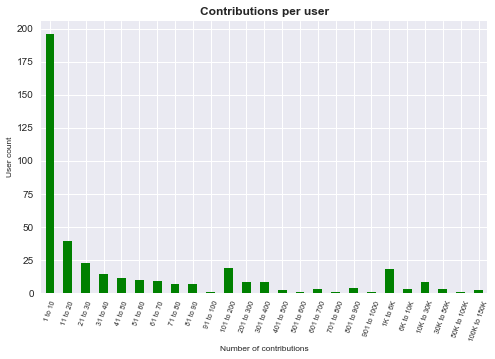

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

for_plot = df_mode_dict.groupby('bracket')['count'].agg('sum')

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)

#all passengers plot
rects = for_plot.plot(kind='bar',ax=ax,color='g')
ax.set_title('Contributions per user',fontsize='large',fontweight='bold')
ax.set_xlabel('Number of contributions',fontsize='small')
ax.set_ylabel('User count',fontsize='small')
ax.set_xticklabels(for_plot.index.values,rotation='70',fontsize='x-small')

plt.show()

In [39]:
total_contributions = 0

for doc in grouped_users:
    try:
        total_contributions += int(doc['count'])
    except TypeError:
        pprint(doc)
    


In [40]:
# Looking at top 10 contributors

top_users = list(bergen.aggregate([  
        { "$group" : { 
                "_id" : { "uid": "$created.uid", "username": "$created.user" },"count" : { "$sum" : 1} } },
        { "$sort" : { "count" : -1 } },
         { "$limit" : 10 }
#         { "$project" : { "_id": 0, "user": "$created.user" } } 
    ]))

for doc in top_users:
    print(doc)
    
print(list(top_users))

#Calculating total user contributions for comparison
total_contributions = 0
for doc in grouped_users:
    try:
        total_contributions += int(doc['count'])
    except TypeError:
        pprint(doc)

print('Total contributors:',total_contributions)

total_top_10 = 0
for doc in top_users:
    total_top_10 += doc['count']

top_10_percentage = round((total_top_10/total_contributions)*100,2)

print('Total contributions by top 10 contributors: {0}, {1}%'.format(total_top_10,top_10_percentage))

{'_id': {'uid': '2114448', 'username': 'FredrikLindseth_import'}, 'count': 140794}
{'_id': {'uid': '2836853', 'username': 'frokor_import'}, 'count': 133655}
{'_id': {'uid': '103253', 'username': 'gormur'}, 'count': 80243}
{'_id': {'uid': '992708', 'username': 'Christian Madsen'}, 'count': 39789}
{'_id': {'uid': '722193', 'username': 'daviesp12'}, 'count': 36440}
{'_id': {'uid': '170061', 'username': 'frokor'}, 'count': 31427}
{'_id': {'uid': '1965308', 'username': 'FredrikLindseth'}, 'count': 29969}
{'_id': {'uid': '715936', 'username': 'Gazer75'}, 'count': 22168}
{'_id': {'uid': '3119148', 'username': 'cmeeren_import'}, 'count': 19287}
{'_id': {'uid': '8313', 'username': 'gisle'}, 'count': 16081}
[{'_id': {'uid': '2114448', 'username': 'FredrikLindseth_import'}, 'count': 140794}, {'_id': {'uid': '2836853', 'username': 'frokor_import'}, 'count': 133655}, {'_id': {'uid': '103253', 'username': 'gormur'}, 'count': 80243}, {'_id': {'uid': '992708', 'username': 'Christian Madsen'}, 'count':

We see here that the large majority of contributions are made by a few users. It seems like a lot of the contributions are automated in some way, as 4 of the top 10 usernames end in "\_import". Any potential contribution patterns these few users have is likely to heavily impact the Bergen OSM data.

According to the address page of the OSM wiki, in mid-2014 all Norwegian official addresses were released to the public. Efforts are being made by OSM volunteers to include the released data in OSM, and the progress is being tracked using a tool called [Beebeetle](http://osm.beebeetle.com/addrnodeimportstatus.php). As of January 7, 2017, the Bergen import is listed as 99.84% complete. 1 known address duplicate is listed on the site.

### Final Thoughts

There are 184 address documents without street names in the dataset. Further investigation into those documments is recommended.


To address the duplicate issue in detail, I suggest following up by looking at the individual duplicate addresses. You could for example start by looking at the three streets with the most individual duplicate addresses to see if there are any useful patterns to be found.

### Sources

SSB: https://ssb.no/befolkning/statistikker/familie/aar/2016-04-14  
SSB: https://www.ssb.no/befolkning/samordnet-statistikk-for-husholdninger-og-boliger  
Kartverket: http://www.seeiendom.no/

OSM resource links:  
http://wiki.openstreetmap.org/wiki/Addresses#How_to_map_addresses  
http://wiki.openstreetmap.org/wiki/Addresses#Norway  
http://osm.beebeetle.com/addrnodeimportstatus.php

OSM links:  
Kanalveien 66 http://www.openstreetmap.org/search?query=kanalveien%2066#map=19/60.36224/5.34696  
